In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import *
from sklearn.preprocessing import StandardScaler

In [2]:
def plotting(W, costs):
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.title('X')
    plt.plot(W[:,0])

    plt.subplot(142)
    plt.title('Y')
    plt.plot(W[:,1])

    plt.subplot(143)
    plt.title('Z')
    plt.plot(W[:,2])    

    plt.subplot(144)
    plt.title('costs')
    plt.plot(costs)
    plt.show()

### Gradient Descent

We are solving the following un-constrained problem:
<center>

minimize $x^{2}+y^{2}+z^{2}$

Solution: $(0,0,0)$

</center>



In [3]:
def loss_fn(w):
    return w.T @ w

def gradient(w):
    return w 

def gradient_descent(w_init, alpha, eps):
    w = w_init
    dw = np.random.random(w_init.shape)
    W = []
    costs = []
    n_iters = 0
    
    while(np.linalg.norm(dw)>eps):
        dw = gradient(w)
        w = w - alpha * dw
        cost = loss_fn(w)

        W.append(w)
        costs.append(cost)
        n_iters+=1
    print(f'Converged in {n_iters} iterations..')
    return np.array(W), costs

w_init = np.array([2,4,8])
alpha = 1E-2
eps = 1E-3
W, costs = gradient_descent(w_init, alpha, eps)
print('Final Solution:', W[-1].tolist())
print('Final Cost:', costs[-1])

Converged in 909 iterations..
Final Solution: [0.00021548740183906885, 0.0004309748036781377, 0.0008619496073562754]
Final Cost: 9.75131227378399e-07


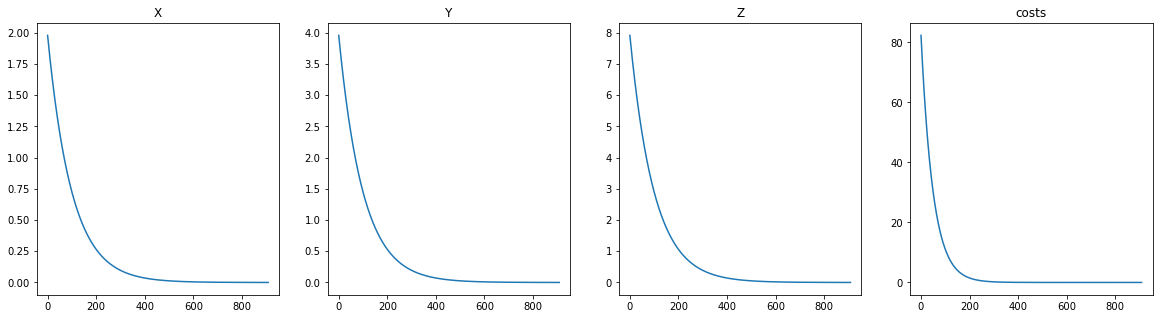

In [4]:
plotting(W, costs)

### Projected Gradient Descent (Gradient Descent with constraints)

The idea behind Projected Gradient Descent is that you constrain the search space by projecting the solution onto your constrained space. Your constrained space can be a sphere, plane etc. This results in obtaining solutions that satisfy our constraints.

We are solving the following constrained problem:
<center>

minimize $x^{2}+y^{2}+z^{2}$

given $x+y+z=1$

Solution: $(\frac{1}{3},\frac{1}{3},\frac{1}{3})$
</center>
The above solution can be found using Lagrange multiplers.

The above problem using PGD is solved with following steps:
1. Changing the origin such that $x'+y'+z'=0$. We are solving for $(x', y', z')$ instead of $(x,y,z)$ now.
2. Projecting solution vector obtained by gradient descent onto the plane $x'+y'+z'=0$. Projection of a vector on plane is obtained by subtracting projection of vector on normal from vector. 
3. Changing origin back to original space to get optimized $(x,y,z)$.

In [5]:
def loss_fn(w, gamma):
    return (w + gamma).T @ (w + gamma)

def gradient(w, gamma):
    return w + gamma

def projection(w, normal_vec):
    projection = w - (w @ normal_vec) * normal_vec / (normal_vec.T @ normal_vec)
    return projection

def projected_gradient_descent(w_init, normal_vec, alpha, gamma, eps, max_iters):
    w = w_init
    dw = np.random.random(w_init.shape)
    W = []
    costs = []
    n_iters = 0
    terminated_flag = 0

    while (np.linalg.norm(dw)>eps):
        dw = gradient(w, gamma)
        w = w - alpha * dw
        w = projection(w, normal_vec)
        cost = loss_fn(w, gamma)

        W.append(w)
        costs.append(cost)
        n_iters+=1
        
        if n_iters>=max_iters:
            terminated_flag = 1
            print(f'Terminated in {n_iters} iterations..')
            break
    if terminated_flag!=1:
        print(f'Converged in {n_iters} iterations..')        
    return np.array(W), costs

w_init = np.array([2,4,8])
normal_vec = np.array([1,1,1])
alpha = 1E-2
gamma = 1/np.shape(w_init)[0]
eps = 1E-3
max_iters = 5000
W, costs = projected_gradient_descent(w_init, normal_vec, alpha, gamma, eps, max_iters)
print('Final Solution:', (W[-1] + gamma).tolist())
print('Final Cost:', costs[-1])

Terminated in 5000 iterations..
Final Solution: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Final Cost: 0.3333333333333333


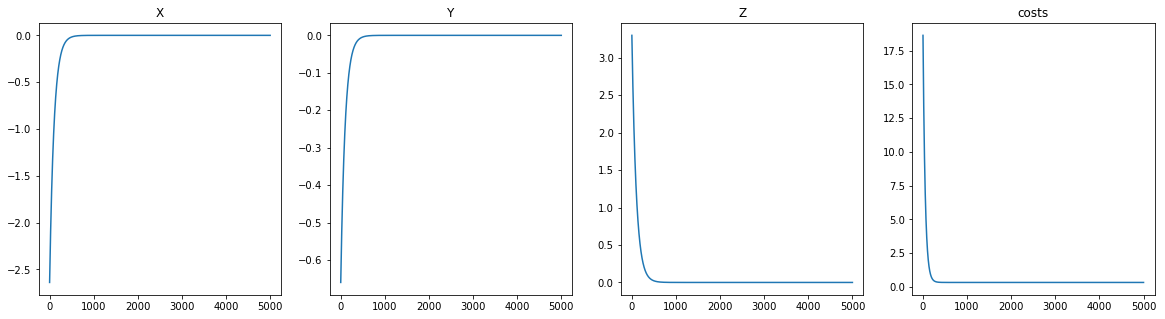

In [6]:
plotting(W, costs)

### Regularization v/s Constrained Optimization

Regularization can be thought of as constraining the search space by imposing some sort of penalty function. It's similar to writing an equivalent Lagrangian form of optimization. Take the case of Ridge Regression, we are interested in undermining the coefficients to prevent model overfitting. Here, we are constraining the coefficients to lie on a hypersphere centered at origin with radius that is inversely proportional to regularization coefficient.

Regularization can also help speed up convergence since it limits the search space. However, while regularizing, you are solving a different optimization problem altogether and you are expected to get different results. 

If we compare regularization with projected gradient descent, these can be thought of as completely different approaches although having similar ideas. We will try solving similar problem using regularization:

$$
\text { minimize } 
w^{\top}w
\\
\text { such that}
\sum_{i=1}^{n}\left|w_{i}\right|=1
$$

Note that the constant term of constraint will not be part of gradient equations, which is why we transform the origin as in previous case. 

The regularized loss function is:
$$
J=\left(w^{\prime}+ \frac{1}{3}\right)^{\top}\left(w^{\prime}+\frac{1}{3}\right)+\lambda\left(\sum_{i=1}^{n}\left|w^{\prime}_{i}\right|\right)
$$

$$
\frac{\partial J}{\partial w^{\prime}}=2\left(w^{\prime}+\frac{1}{3}\right)+\lambda \operatorname{sgn}(w^{\prime})
$$


Note that the **cost is different from our regularized loss function**. Cost is sum of squares of weights while the loss function also contains the regularized term.

In [7]:
def loss_fn(w, gamma, reg_coef):
    return (w + gamma).T @ (w + gamma) + reg_coef * sum(abs(w))

# derivative of loss function
def gradient(w, gamma, reg_coef):
    return 2 * (w + gamma) + reg_coef * np.sign(w)

def projected_gradient_descent(w_init, alpha, gamma, reg_coef, eps, max_iters, verbose=False):
    w = w_init
    dw = np.random.random(w_init.shape)
    W = []
    costs = []
    n_iters = 0
    terminated_flag = 0

    while (np.linalg.norm(dw)>eps):
        dw = gradient(w, gamma, reg_coef)
        w = w - alpha * dw
        # cost is different from loss function
        # our cost is wTw
        cost = (w + gamma).T @ (w + gamma)

        W.append(w)
        costs.append(cost)
        n_iters+=1
        
        if n_iters>=max_iters:
            terminated_flag = 1
            break
    if verbose:
        if terminated_flag!=1:
            print(f'Converged in {n_iters} iterations..')        
        else:
            print(f'Terminated in {n_iters} iterations..')
    return np.array(W), costs, n_iters

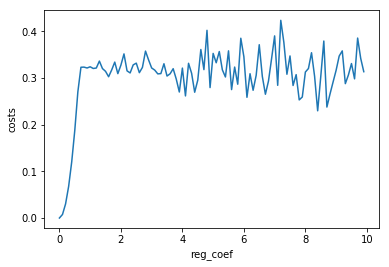

In [8]:
w_init = np.array([2,4,8])
alpha = 1E-2
gamma = 1 / np.shape(w_init)[0]
eps = 1E-3
max_iters = 500
reg_coefs = np.arange(0,10,0.1)
final_costs = []

for reg_coef in reg_coefs:
    W, costs, n_iters = projected_gradient_descent(w_init, alpha, gamma, reg_coef, eps, max_iters, verbose=False)
    final_costs.append(costs[-1])

plt.plot(reg_coefs, final_costs)
plt.xlabel('reg_coef')
plt.ylabel('costs')
plt.show()

This shows that as you increase the regularizing coefficient, you are bringing the plane $|x'|+|y'|+|z'|$ closer to $(0,0,0)$ or $(x,y,z)$ closer to $(\frac{1}{3},\frac{1}{3},\frac{1}{3})$. You are imposing higher penalty and constraining the search space strongly.

In [9]:
reg_coef = 1
W, costs, n_iters = projected_gradient_descent(w_init, alpha, gamma, reg_coef, eps, 50000, verbose=True)
print('Final Solution:', (W[-1] + gamma).tolist())
print('Final Cost:', costs[-1])

Terminated in 50000 iterations..
Final Solution: [0.3322093753655265, 0.329506724884837, 0.3229044165949742]
Final Cost: 0.32320501308162564


### Constrained Least Squares Regression 

We will build a regression model on California housing dataset while imposing certain constraints. The constraints are:
1. As income of group increase, target value increases
2. As age of house increases, target value decreases

We will impose these constraints by projecting the vector onto constraint space.

In [10]:
dataset = fetch_california_housing()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names']).astype('int')
target = pd.DataFrame(dataset['target'], columns=dataset['target_names']).astype('int')
df = pd.concat([df, target], axis=1)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8,41,6,1,322,2,37,-122,4
1,8,21,6,0,2401,2,37,-122,3
2,7,52,8,1,496,2,37,-122,3
3,5,52,5,1,558,2,37,-122,3
4,3,52,6,1,565,2,37,-122,3


In [11]:
X = df.values[:,[0,1,2,3,5]]
Y = df.values[:,-1]

# normalizing due to high variation in range of variables
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape, Y.shape

((20640, 5), (20640,))

In [12]:
def loss_fn(theta, X, Y):
    return (Y-X@theta).T @ (Y-X@theta)

def gradient(theta, X, Y):
    dtheta = 2 * (X.T @ X @ theta - X.T @ Y)
    return dtheta

def projection(theta):
    if theta[0]<0:
        theta[0] = 0
    if theta[1]>0:
        theta[1] = 0
    return theta    

def projected_gradient_descent(theta_init, X, Y, alpha, eps, max_iters, allow_constraints=False):
    theta = theta_init
    dtheta = np.random.random(theta_init.shape)
    thetas = []
    costs = []
    n_iters = 0
    terminated_flag = 0

    while (np.linalg.norm(dtheta)>eps):
        dtheta = gradient(theta, X, Y)
        theta = theta - alpha * dtheta

        # constraints
        if allow_constraints:
            theta = projection(theta)

        cost = loss_fn(theta, X, Y)
        thetas.append(theta)
        costs.append(cost)
        n_iters+=1
        
        if n_iters>=max_iters:
            terminated_flag = 1
            print(f'Terminated in {n_iters} iterations..')
            break
    if terminated_flag!=1:
        print(f'Converged in {n_iters} iterations..')        
    return np.array(thetas), costs

In [13]:
theta_init = np.random.random(X.shape[1])
alpha = 1E-5
eps = 1E-3
max_iters = 5000

print('Without Constraints:')
thetas, costs = projected_gradient_descent(theta_init, X, Y, alpha, eps, max_iters, allow_constraints=False)
print('Final Solution:', (thetas[-1]).round(3).tolist())
print('Final Cost:', costs[-1])

print()
print('With Constraints:')
thetas, costs = projected_gradient_descent(theta_init, X, Y, alpha, eps, max_iters, allow_constraints=True)
print('Final Solution:', (thetas[-1]).round(3).tolist())
print('Final Cost:', costs[-1])

Without Constraints:
Converged in 138 iterations..
Final Solution: [0.965, 0.228, -0.228, 0.221, -0.048]
Final Cost: 67658.53460640686

With Constraints:
Terminated in 5000 iterations..
Final Solution: [0.946, 0.0, -0.255, 0.217, -0.045]
Final Cost: 68702.59083450891
